In [1]:
#Librerias necesarias
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, StratifiedKFold
from catboost import CatBoostRegressor, metrics

In [2]:
#Cargamos el dataset limpio ajustando la cantidad de decimales
pd.options.display.float_format = '{:.6f}'.format

data = pd.read_csv('dataclean.csv')
data.drop(['Unnamed: 0'],axis=1,inplace=True)
pd.set_option('display.max_columns', None)
data.sample(3)

,host_is_superhost,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,host_days_active,cable,air_conditioning,outdoor,pool,parking,tv,internet,white_goods,gym,pet_friendly,dishes_silverware,essentials,grill,kitchen,heating,elevator,refrigerator,freezer,phone_verification,email_verification,neighbourhood_cleansed_Agronomia,neighbourhood_cleansed_Almagro,neighbourhood_cleansed_Balvanera,neighbourhood_cleansed_Barracas,neighbourhood_cleansed_Belgrano,neighbourhood_cleansed_Boca,neighbourhood_cleansed_Boedo,neighbourhood_cleansed_Caballito,neighbourhood_cleansed_Chacarita,neighbourhood_cleansed_Coghlan,neighbourhood_cleansed_Colegiales,neighbourhood_cleansed_Constitucion,neighbourhood_cleansed_Flores,neighbourhood_cleansed_Floresta,neighbourhood_cleansed_Liniers,neighbourhood_cleansed_Mataderos,neighbourhood_cleansed_Monserrat,neighbourhood_cleansed_Monte Castro,neighbourhood_cleansed_Nueva Pompeya,neighbourhood_cleansed_Nuñez,neighbourhood_cleansed_Palermo,neighbourhood_cleansed_Parque Avellaneda,neighbourhood_cleansed_Parque Chacabuco,neighbourhood_cleansed_Parque Chas,neighbourhood_cleansed_Parque Patricios,neighbourhood_cleansed_Paternal,neighbourhood_cleansed_Puerto Madero,neighbourhood_cleansed_Recoleta,neighbourhood_cleansed_Retiro,neighbourhood_cleansed_Saavedra,neighbourhood_cleansed_San Cristobal,neighbourhood_cleansed_San Nicolas,neighbourhood_cleansed_San Telmo,neighbourhood_cleansed_Velez Sarsfield,neighbourhood_cleansed_Versalles,neighbourhood_cleansed_Villa Crespo,neighbourhood_cleansed_Villa Del Parque,neighbourhood_cleansed_Villa Devoto,neighbourhood_cleansed_Villa Gral. Mitre,neighbourhood_cleansed_Villa Lugano,neighbourhood_cleansed_Villa Luro,neighbourhood_cleansed_Villa Ortuzar,neighbourhood_cleansed_Villa Pueyrredon,neighbourhood_cleansed_Villa Real,neighbourhood_cleansed_Villa Riachuelo,neighbourhood_cleansed_Villa Santa Rita,neighbourhood_cleansed_Villa Soldati,neighbourhood_cleansed_Villa Urquiza,property_type_Apartment,property_type_House,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bathroomtype_private,bathroomtype_shared
13135,0,1,2,1,1,1,3619,3,40,7,5.000000,1543,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0
11310,0,1,2,1,1,1,6369,3,365,7,5.000000,4035,0,1,0,0,0,1,1,1,0,0,1,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0
5680,0,1,4,1,1,2,10856,4,1125,1,5.000000,3167,1,1,1,0,1,1,1,1,0,0,1,1,1,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16150 entries, 0 to 16149
Data columns (total 87 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   host_is_superhost                         16150 non-null  int64  
 1   host_identity_verified                    16150 non-null  int64  
 2   accommodates                              16150 non-null  int64  
 3   bathrooms                                 16150 non-null  int64  
 4   bedrooms                                  16150 non-null  int64  
 5   beds                                      16150 non-null  int64  
 6   price                                     16150 non-null  int64  
 7   minimum_nights                            16150 non-null  int64  
 8   maximum_nights                            16150 non-null  int64  
 9   number_of_reviews                         16150 non-null  int64  
 10  review_scores_rating              

In [4]:
#Genero mi variable X
X=data.drop(['price'],axis=1)

#Genero la variable y
y = data['price']

#Creamos las muestras
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10,shuffle=True)

In [5]:
def calcularMetricas(model, X_train, y_train, X_test, y_test, model_prediction_train, model_prediction, name):

    try:
       

        coeff = model.coef_
        n = len(y_test)
        p = np.count_nonzero(coeff)

        #r2:
        r2_test = model.score(X_test, y_test)
        r2_train = model.score(X_train, y_train)

        #r2 adj:
        r2_adj_test = 1-((1-r2_test)*((len(y_test)-1)/(len(y_test)-p-1)))
        r2_adj_train = 1-((1-r2_train)*((len(y_train)-1)/(len(y_train)-p-1)))

        #mse:
        mse_test = mean_squared_error(y_test, model_prediction)
        mse_train = mean_squared_error(y_train, model_prediction_train)

        #mae:
        mae_test = mean_absolute_error(y_test, model_prediction)
        mae_train = mean_absolute_error(y_train, model_prediction_train)

        #rmse:
        rmse_test = np.sqrt(mse_test)
        rmse_train = np.sqrt(mse_train)


        stats=[mse_test, mse_train,
                mae_test, mae_train, 
                rmse_test,rmse_train,
                r2_test,r2_train,
                r2_adj_test,r2_adj_train
             ]

        stats=pd.DataFrame({name:stats},index=['MSE Test', 'MSE Train', 'MAE Test', 'MAE Train', 'RMSE Test', 'RMSE Train', 'R2 Test','R2 Train', 'R2 Adj Test','R2 Adj Train'])

        return stats
    
    except:
 
        #r2:
        r2_test = model.score(X_test, y_test)
        r2_train = model.score(X_train, y_train)
        
        #mse:
        mse_test = mean_squared_error(y_test, model_prediction)
        mse_train = mean_squared_error(y_train, model_prediction_train)

        #mae:
        mae_test = mean_absolute_error(y_test, model_prediction)
        mae_train = mean_absolute_error(y_train, model_prediction_train)
        
        #rmse:
        rmse_test = np.sqrt(mse_test)
        rmse_train = np.sqrt(mse_train)
        
        stats=[mse_test, mse_train,
        mae_test, mae_train, 
        rmse_test, rmse_train,
        r2_test,r2_train,
        ]

        stats=pd.DataFrame({name:stats},index=['MSE Test', 'MSE Train', 'MAE Test', 'MAE Train', 'RMSE Test', 'RMSE Train', 'R2 Test', 'R2 Train'])
        
        return stats

### Linear Regression

In [88]:
#Entrenamos modelo LR
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

#Predecimos
lr_prediction = model_lr.predict(X_test)
lr_prediction_train = model_lr.predict(X_train)

In [89]:
m_lr = calcularMetricas(model_lr, X_train, y_train, X_test, y_test, lr_prediction_train, lr_prediction, 'LR')

In [90]:
m_lr

,LR
MSE Test,6748422.175065
MSE Train,6948485.098518
MAE Test,1934.151558
MAE Train,1958.277827
RMSE Test,2597.772541
RMSE Train,2635.997932
R2 Test,0.388673
R2 Train,0.409225
R2 Adj Test,0.377624
R2 Adj Train,0.404696


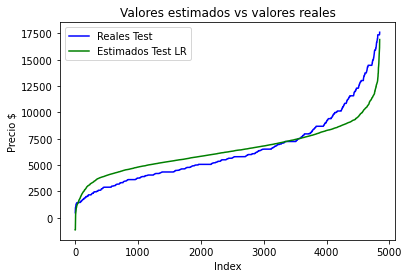

In [96]:
eje_X=range(1,len(y_test)+1)
plt.plot(eje_X, sorted(y_test), color='blue', label='Reales Test')
plt.plot(eje_X, sorted(lr_prediction), color='green', label='Estimados Test LR')
plt.legend()
plt.title('Valores estimados vs valores reales')
plt.xlabel('Index')
plt.ylabel('Precio $')
plt.show()

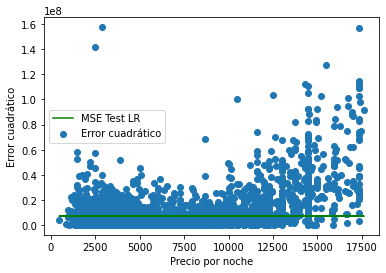

In [10]:
#Qué tan alejados están los valores del error cuadrático medio MSE TEST
err_cuad_test_lr=pow(y_test - lr_prediction,2)
plt.scatter(y_test, err_cuad_test_lr, label = 'Error cuadrático')
plt.plot(y_test,np.repeat(m_lr.loc['MSE Test'],len(err_cuad_test_lr)), label='MSE Test LR', color='green')
plt.legend()
plt.xlabel('Precio por noche')
plt.ylabel('Error cuadrático')
plt.show()

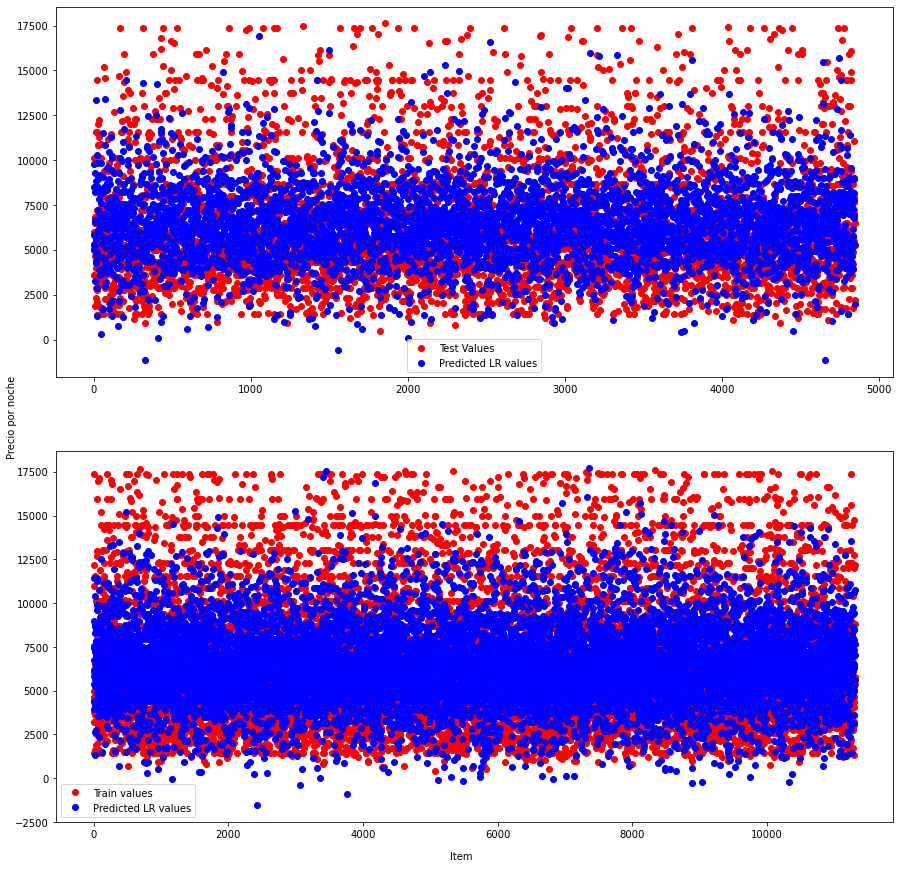

In [92]:
#Gráfico de los valores vs los predecidos
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

axes[0].plot([i for i in range(len(y_test))],y_test, 'ro', label="Test Values")
axes[0].plot([i for i in range(len(y_test))],lr_prediction, 'bo', label="Predicted LR values")
axes[0].legend()

axes[1].plot([i for i in range(len(y_train))],y_train, 'ro', label="Train values")
axes[1].plot([i for i in range(len(y_train))],lr_prediction_train, 'bo', label="Predicted LR values")
axes[1].legend()

fig.text(0.5, 0.09, 'Item', ha='center')
fig.text(0.08, 0.5, 'Precio por noche', va='center', rotation='vertical')
plt.show()

### Lasso

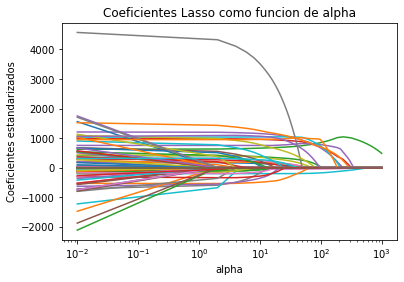

In [11]:
#Análisis previo de los alpha
alphas_lasso = np.linspace(0.01,1000,500)
lasso = linear_model.Lasso(max_iter = 10000, normalize = False)
coefs = []

for a in alphas_lasso:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas_lasso, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coeficientes estandarizados')
plt.title('Coeficientes Lasso como funcion de alpha');

In [12]:
#Creamos el modelo
lassocv = linear_model.LassoCV(alphas=None,normalize=False,cv=10,random_state=10, max_iter=10000)

#Fit y predict

model_lasso = lassocv.fit(X_train, y_train)
lasso_prediction = model_lasso.predict(X_test)
lasso_prediction_train = model_lasso.predict(X_train)

In [64]:
m_lasso = calcularMetricas(lassocv, X_train, y_train, X_test, y_test, lasso_prediction_train, lasso_prediction, "Lasso")

In [65]:
m_lasso

,Lasso
MSE Test,8905480.287197
MSE Train,9384542.399704
MAE Test,2258.364016
MAE Train,2330.756421
RMSE Test,2984.205135
RMSE Train,3063.420050
R2 Test,-544688.248760
R2 Train,-520792.432435
R2 Adj Test,-550598.900041
R2 Adj Train,-523199.227536


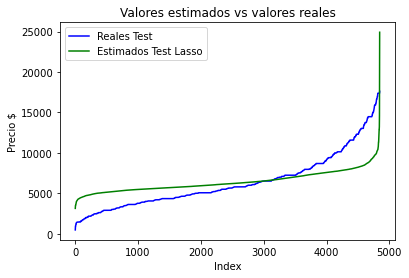

In [97]:
eje_X=range(1,len(y_test)+1)
plt.plot(eje_X, sorted(y_test), color='blue', label='Reales Test')
plt.plot(eje_X, sorted(lasso_prediction), color='green', label='Estimados Test Lasso')
plt.legend()
plt.title('Valores estimados vs valores reales')
plt.xlabel('Index')
plt.ylabel('Precio $')
plt.show()

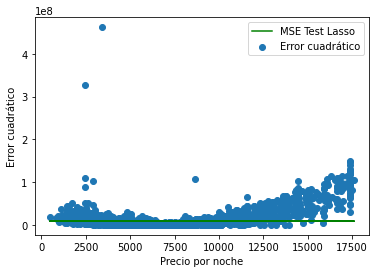

In [98]:
#Qué tan alejados están los valores del error cuadrático medio MSE TEST
err_cuad_test_lasso=pow(y_test - lasso_prediction,2)
plt.scatter(y_test, err_cuad_test_lasso, label = 'Error cuadrático')
plt.plot(y_test,np.repeat(m_lasso.loc['MSE Test'],len(err_cuad_test_lasso)), label='MSE Test Lasso', color='green')
plt.legend()
plt.xlabel('Precio por noche')
plt.ylabel('Error cuadrático')
plt.show()

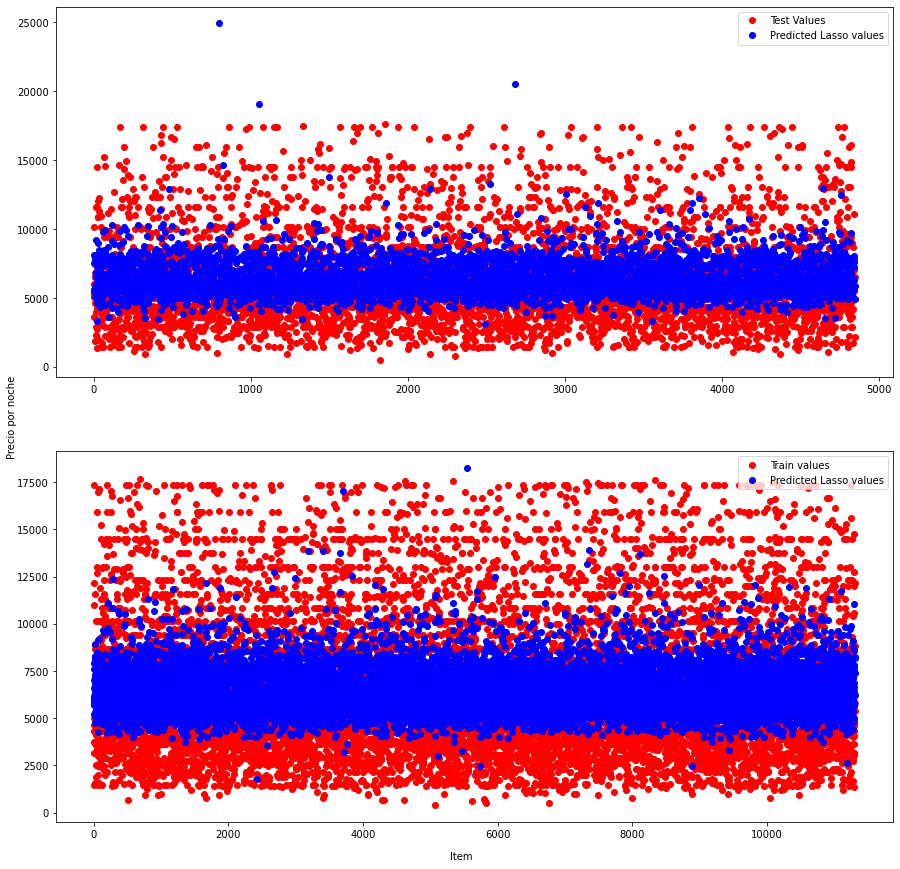

In [99]:
#Gráfico de los valores vs los predecidos
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

axes[0].plot([i for i in range(len(y_test))],y_test, 'ro', label="Test Values")
axes[0].plot([i for i in range(len(y_test))],lasso_prediction, 'bo', label="Predicted Lasso values")
axes[0].legend()

axes[1].plot([i for i in range(len(y_train))],y_train, 'ro', label="Train values")
axes[1].plot([i for i in range(len(y_train))],lasso_prediction_train, 'bo', label="Predicted Lasso values")
axes[1].legend()

fig.text(0.5, 0.09, 'Item', ha='center')
fig.text(0.08, 0.5, 'Precio por noche', va='center', rotation='vertical')
plt.show()

### Ridge

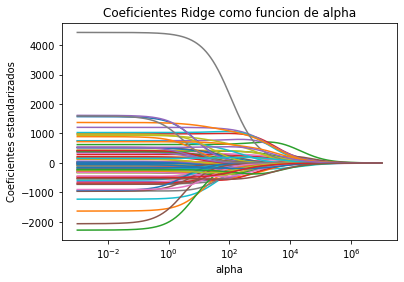

In [17]:
#Análisis previo de los alpha

alphas_ridge = np.logspace(-3, 7,400)
ridge = linear_model.Ridge(max_iter=10000)
coefs = []

for a in alphas_ridge:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)

ax = plt.gca()

ax.plot(alphas_ridge, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coeficientes estandarizados')
plt.title('Coeficientes Ridge como funcion de alpha');

In [18]:
#Creamos el modelo
ridgecv = linear_model.RidgeCV(alphas=alphas_ridge,normalize=False,cv=10)

#Fit y predict
model_ridge = ridgecv.fit(X_train, y_train)
ridge_prediction = model_ridge.predict(X_test)
ridge_prediction_train = model_ridge.predict(X_train)

In [66]:
m_ridge = calcularMetricas(ridgecv, X_train, y_train, X_test, y_test, ridge_prediction_train, ridge_prediction, "Ridge")

In [67]:
m_ridge

,Ridge
MSE Test,6753332.257666
MSE Train,6956910.872010
MAE Test,1934.313440
MAE Train,1959.419695
RMSE Test,2598.717426
RMSE Train,2637.595661
R2 Test,0.388229
R2 Train,0.408509
R2 Adj Test,0.377171
R2 Adj Train,0.403975


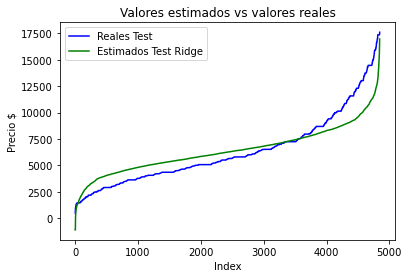

In [100]:
eje_X=range(1,len(y_test)+1)
plt.plot(eje_X, sorted(y_test), color='blue', label='Reales Test')
plt.plot(eje_X, sorted(ridge_prediction), color='green', label='Estimados Test Ridge')
plt.legend()
plt.title('Valores estimados vs valores reales')
plt.xlabel('Index')
plt.ylabel('Precio $')
plt.show()

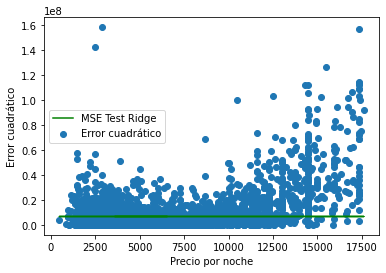

In [101]:
#Qué tan alejados están los valores del error cuadrático medio MSE TEST
err_cuad_test_ridge=pow(y_test - ridge_prediction,2)
plt.scatter(y_test, err_cuad_test_ridge, label = 'Error cuadrático')
plt.plot(y_test,np.repeat(m_ridge.loc['MSE Test'],len(err_cuad_test_ridge)), label='MSE Test Ridge', color='green')
plt.legend()
plt.xlabel('Precio por noche')
plt.ylabel('Error cuadrático')
plt.show()

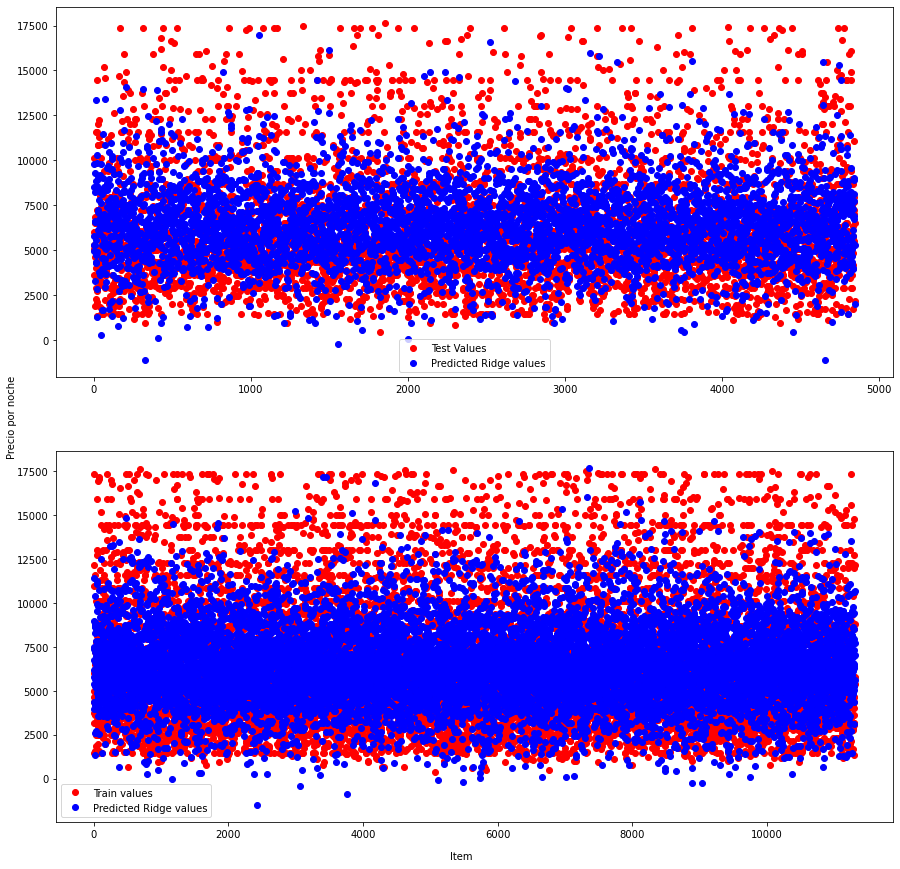

In [102]:
#Gráfico de los valores vs los predecidos
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

axes[0].plot([i for i in range(len(y_test))],y_test, 'ro', label="Test Values")
axes[0].plot([i for i in range(len(y_test))],ridge_prediction, 'bo', label="Predicted Ridge values")
axes[0].legend()

axes[1].plot([i for i in range(len(y_train))],y_train, 'ro', label="Train values")
axes[1].plot([i for i in range(len(y_train))],ridge_prediction_train, 'bo', label="Predicted Ridge values")
axes[1].legend()

fig.text(0.5, 0.09, 'Item', ha='center')
fig.text(0.08, 0.5, 'Precio por noche', va='center', rotation='vertical')
plt.show()

#### Si normalizo las variables:

In [24]:
#Normalizo:

data_normalizar=data.drop(['price'],axis=1)
numericals = data_normalizar.columns

X = data_normalizar[numericals]

scaler = MinMaxScaler()
scaler.fit(X)

std_numerical_data = scaler.transform(X)
std_df = pd.DataFrame(std_numerical_data)
std_df.columns = [i for i in numericals]

In [25]:
#Genero mi variable X
X_std= std_df

#Genero la variable y
y_std = data['price'].squeeze()

#Creamos las muestras
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X_std, y_std, test_size = 0.3, random_state = 10,shuffle=True)

In [68]:
#LR:

model_lr_std = LinearRegression()
model_lr_std.fit(X_train_std, y_train_std)
lr_prediction_std = model_lr_std.predict(X_test_std)
lr_prediction_train_std = model_lr_std.predict(X_train_std)
m_lr_std = calcularMetricas(model_lr_std, X_train_std, y_train_std, X_test_std, y_test_std, lr_prediction_train_std,lr_prediction_std, 'LR Std')


# Alphas

alphas_lasso = np.linspace(0.01,1000,500)
alphas_ridge = np.logspace(-3, 7,400)
lasso = linear_model.Lasso(max_iter = 10000, normalize = False)
ridge = linear_model.Ridge(max_iter=10000)
coefs_lasso = []
coefs_ridge = []


for a in alphas_lasso:
    lasso.set_params(alpha=a)
    lasso.fit(X_train_std, y_train_std)
    coefs_lasso.append(lasso.coef_)


for a in alphas_ridge:
    ridge.set_params(alpha=a)
    ridge.fit(X_train_std, y_train_std)
    coefs_ridge.append(ridge.coef_)

#Lasso:

lassocv_std = linear_model.LassoCV(alphas=None,normalize=False,cv=10,random_state=10, max_iter=10000)
lassocv_std = lassocv.fit(X_train_std, y_train_std)
lasso_prediction_std = lassocv_std.predict(X_test_std)
lasso_prediction_train_std = lassocv_std.predict(X_train_std)
m_lasso_std = calcularMetricas(lassocv, X_train_std, y_train_std, X_test_std, y_test_std, lasso_prediction_train_std, lasso_prediction_std, "Lasso Std")

#Ridge:

ridgecv_std = linear_model.RidgeCV(alphas=alphas_ridge,normalize=False,cv=10)
ridgecv_std = ridgecv_std.fit(X_train_std, y_train_std)
ridge_prediction_std = ridgecv_std.predict(X_test)
ridge_prediction_train_std = ridgecv_std.predict(X_train_std)
m_ridge_std = calcularMetricas(ridgecv_std, X_train_std, y_train_std, X_test_std, y_test_std, ridge_prediction_train_std, ridge_prediction_std, "Ridge Std")

In [69]:
metricas = m_lr.join(m_lr_std)
metricas = metricas.join(m_lasso)
metricas = metricas.join(m_lasso_std)
metricas = metricas.join(m_ridge)
metricas = metricas.join(m_ridge_std)

In [70]:
metricas

,LR,LR Std,Lasso,Lasso Std,Ridge,Ridge Std
MSE Test,6748422.175065,6748489.069969,8905480.287197,6749667.578978,6753332.257666,7768406274890.990234
MSE Train,6948485.098518,6949193.254578,9384542.399704,6973799.566954,6956910.872010,6952803.740789
MAE Test,1934.151558,1934.340144,2258.364016,1933.475355,1934.313440,2490198.025478
MAE Train,1958.277827,1957.960814,2330.756421,1961.438373,1959.419695,1959.348260
RMSE Test,2597.772541,2597.785416,2984.205135,2598.012236,2598.717426,2787186.085444
RMSE Train,2635.997932,2636.132253,3063.420050,2640.795253,2637.595661,2636.816971
R2 Test,0.388673,0.388667,-544688.248760,0.388561,0.388229,0.389235
R2 Train,0.409225,0.409165,-520792.432435,0.407073,0.408509,0.408858
R2 Adj Test,0.377624,0.377618,-550598.900041,0.381926,0.377171,0.378195
R2 Adj Train,0.404696,0.404636,-523199.227536,0.404333,0.403975,0.404326


### Random Forest Regression

In [104]:
scaler = StandardScaler()
X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)
cv = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)

In [105]:
regressor_rfr = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
regressor_rfr.fit(X_train, y_train.squeeze())

RandomForestRegressor(n_jobs=-1, random_state=42)

In [108]:
y_train_rfr_preds = regressor_rfr.predict(X_train)
y_test_rfr_preds = regressor_rfr.predict(X_test)

m_rf = calcularMetricas(regressor_rfr, X_train, y_train, X_test, y_test, y_train_rfr_preds, y_test_rfr_preds, "Random Forest")

In [109]:
m_rf

,Random Forest
MSE Test,6025336.410905
MSE Train,906869.087531
MAE Test,1779.246853
MAE Train,686.460624
RMSE Test,2454.656068
RMSE Train,952.296743
R2 Test,0.454176
R2 Train,0.922896


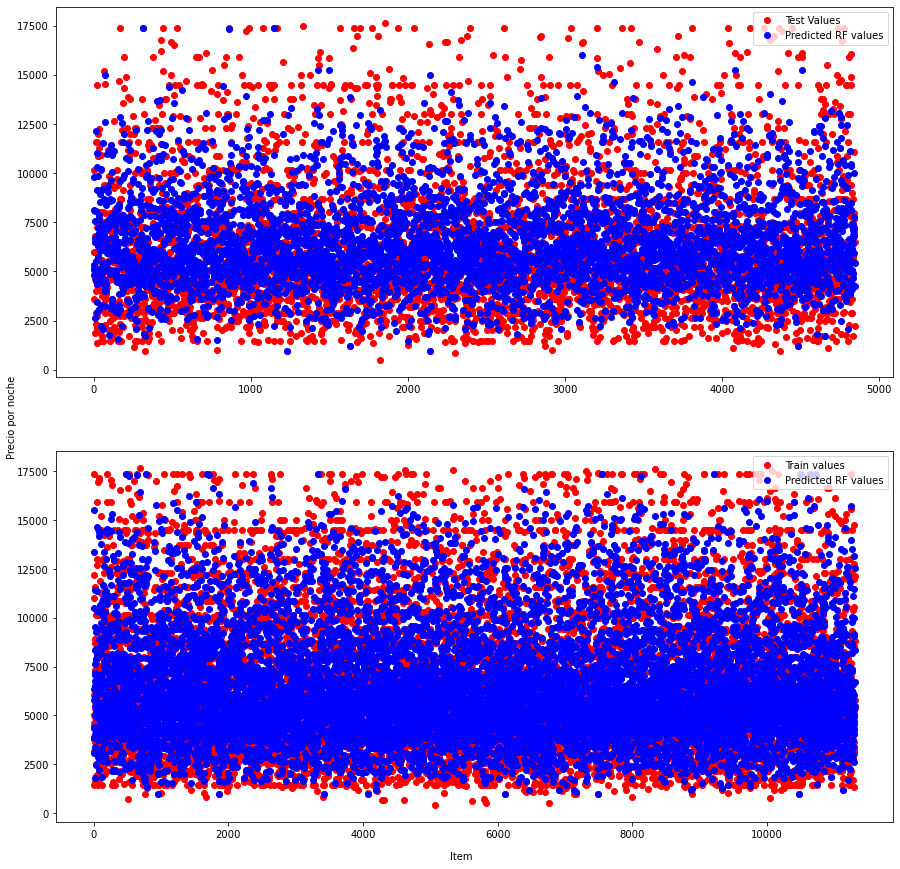

In [112]:
#Gráfico de los valores vs los predecidos
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

axes[0].plot([i for i in range(len(y_test))],y_test, 'ro', label="Test Values")
axes[0].plot([i for i in range(len(y_test))],y_test_rfr_preds, 'bo', label="Predicted RF values")
axes[0].legend()

axes[1].plot([i for i in range(len(y_train))],y_train, 'ro', label="Train values")
axes[1].plot([i for i in range(len(y_train))],y_train_rfr_preds, 'bo', label="Predicted RF values")
axes[1].legend()

fig.text(0.5, 0.09, 'Item', ha='center')
fig.text(0.08, 0.5, 'Precio por noche', va='center', rotation='vertical')
plt.show()

Text(0.5, 1.0, 'CABA feature importances')

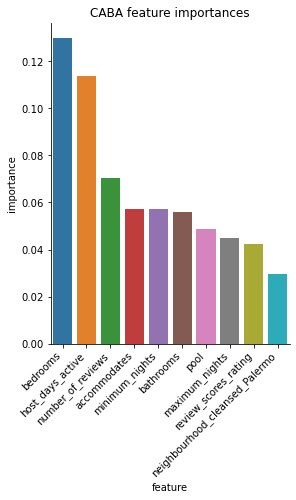

In [111]:
#Feature importancies ranking plot foSeattle's reviews¶
importances = regressor_rfr.feature_importances_
feat_names = X.columns
tree_result = pd.DataFrame({'feature': feat_names, 'importance': importances})
tree_result_sort = tree_result.sort_values(by='importance',ascending=False)[:10]
chart = sns.catplot(x='feature', y='importance', kind='bar', data=tree_result_sort)
chart.set_xticklabels(rotation=45, horizontalalignment='right')
plt.title(label= "CABA feature importances", fontdict=None, loc='center', pad=None)

### XGBoost Regressor

In [52]:
param_dist = {'colsample_bytree': [0.5, 0.7],
              'learning_rate': [0.01, 0.05],
              'max_depth': [9, 10],
              'min_child_weight': [1],
              'n_estimators': [1000],
              'subsample': [0.5, 0.7],
             }

xgb_model = xgb.XGBRegressor()
xgb_grid=GridSearchCV(xgb_model, param_grid = param_dist, cv=cv,verbose=1, n_jobs=-1,scoring='neg_root_mean_squared_error')
xgb_grid.fit(X_train,y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


E:\Programas\anaconda3\envs\dhdsblend2021\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  2.0min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=41, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_ch...None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
                                  

In [53]:
xgb_grid.best_params_

{'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 2000}

In [54]:
xgb_grid.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=2000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [60]:
y_pred_test_xg = xgb_grid.best_estimator_.predict(X_test)
y_pred_train_xg = xgb_grid.best_estimator_.predict(X_train)

m_lasso = calcularMetricas(xgb_grid, X_train, y_train, X_test, y_test, y_pred_train_xg, y_pred_test_xg, "XGB")

In [61]:
m_lasso

,XGB
MSE Test,5910481.232616
MSE Train,3204923.629475
MAE Test,1748.892796
MAE Train,1287.529493
RMSE Test,2431.148131
RMSE Train,1790.230049
R2 Test,0.464581
R2 Train,0.727511


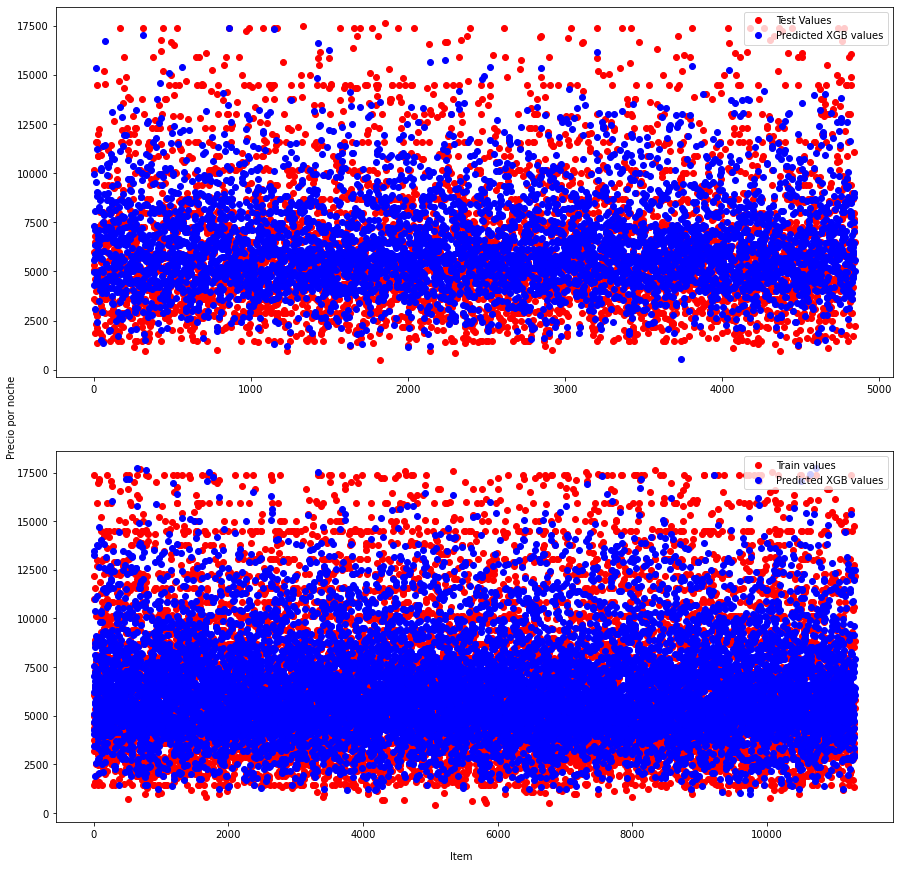

In [113]:
#Gráfico de los valores vs los predecidos
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

axes[0].plot([i for i in range(len(y_test))],y_test, 'ro', label="Test Values")
axes[0].plot([i for i in range(len(y_test))],y_pred_test_xg, 'bo', label="Predicted XGB values")
axes[0].legend()

axes[1].plot([i for i in range(len(y_train))],y_train, 'ro', label="Train values")
axes[1].plot([i for i in range(len(y_train))],y_pred_train_xg, 'bo', label="Predicted XGB values")
axes[1].legend()

fig.text(0.5, 0.09, 'Item', ha='center')
fig.text(0.08, 0.5, 'Precio por noche', va='center', rotation='vertical')
plt.show()

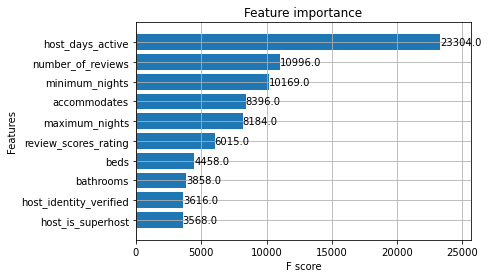

In [114]:
from xgboost import plot_importance
plot_importance(xgb_grid.best_estimator_, height = 0.8,max_num_features=10);

### LGBM

In [71]:

params_lgb = {  
    "n_estimators": [2000,4000], 
    "max_depth": [8], 
    "learning_rate": [0.01],  
}

lgb_model = lgb.LGBMRegressor()
lgb_grid = GridSearchCV(lgb_model, param_grid=params_lgb, cv=cv, verbose=1, n_jobs=-1)
lgb_grid.fit(X_train,y_train)


Fitting 5 folds for each of 2 candidates, totalling 10 fits


E:\Programas\anaconda3\envs\dhdsblend2021\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   14.8s remaining:    9.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   19.2s finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=41, shuffle=True),
             estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01], 'max_depth': [8],
                         'n_estimators': [2000, 4000]},
             verbose=1)

In [72]:
lgb_grid.best_params_

{'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 2000}

In [73]:
lgb_grid.best_estimator_

LGBMRegressor(learning_rate=0.01, max_depth=8, n_estimators=2000)

In [78]:
y_pred_test_lgb = lgb_grid.best_estimator_.predict(X_test)
y_pred_train_lgb = lgb_grid.best_estimator_.predict(X_train)
m_lgb = calcularMetricas(lgb_grid, X_train, y_train, X_test, y_test, y_pred_train_lgb, y_pred_test_lgb, 'LGB')

In [79]:
m_lgb

,LGB
MSE Test,5908514.115942
MSE Train,3999226.025525
MAE Test,1751.625952
MAE Train,1453.266797
RMSE Test,2430.743532
RMSE Train,1999.806497
R2 Test,0.464759
R2 Train,0.659978


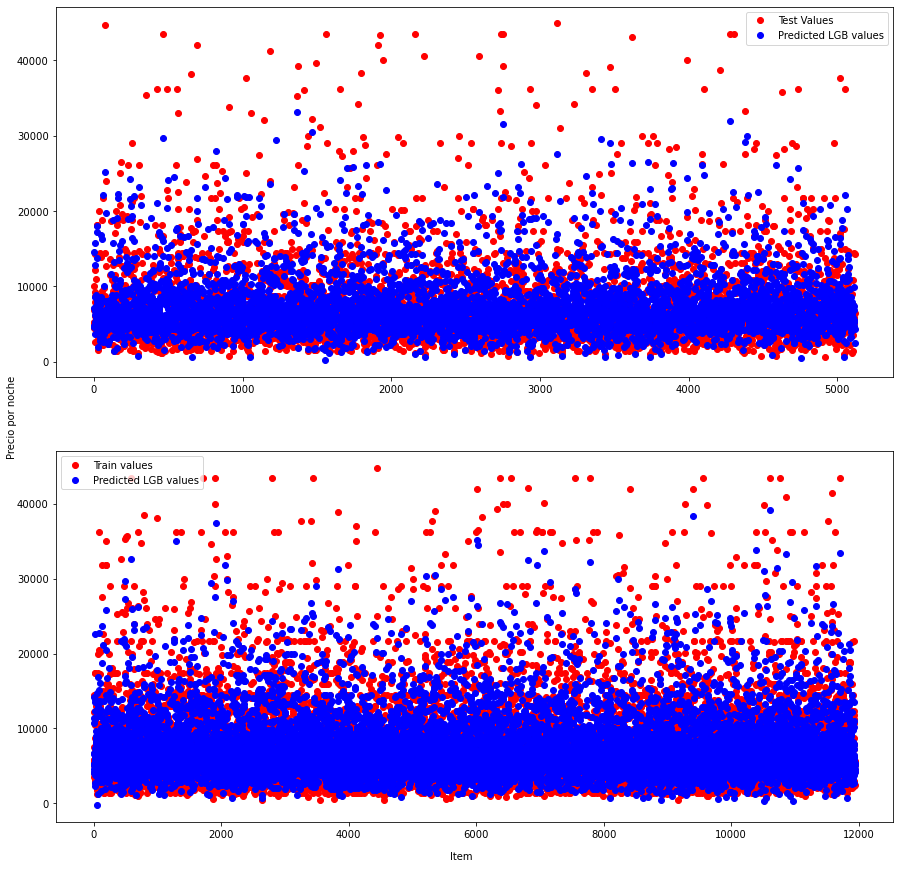

In [37]:
#Gráfico de los valores vs los predecidos
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

axes[0].plot([i for i in range(len(y_test))],y_test, 'ro', label="Test Values")
axes[0].plot([i for i in range(len(y_test))],y_pred_test_lgb, 'bo', label="Predicted LGB values")
axes[0].legend()

axes[1].plot([i for i in range(len(y_train))],y_train, 'ro', label="Train values")
axes[1].plot([i for i in range(len(y_train))],y_pred_train_lgb, 'bo', label="Predicted LGB values")
axes[1].legend()

fig.text(0.5, 0.09, 'Item', ha='center')
fig.text(0.08, 0.5, 'Precio por noche', va='center', rotation='vertical')
plt.show()

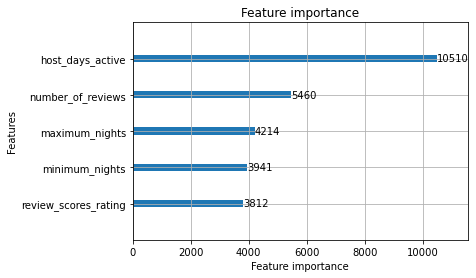

In [38]:
lgb.plot_importance(lgb_grid.best_estimator_, max_num_features=5);

### CatBoost Regressor

In [80]:
parameters_CBR = {'depth'         : [9],
                  'learning_rate' : [0.06],
                  'iterations'    : [1003]
                 }

CBR_model = CatBoostRegressor()
Grid_CBR = GridSearchCV(CBR_model, param_grid = parameters_CBR, cv = cv, verbose = 1, n_jobs=-1)
Grid_CBR.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


E:\Programas\anaconda3\envs\dhdsblend2021\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.6s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.2s finished


0:	learn: 3366.4234775	total: 171ms	remaining: 2m 51s
1:	learn: 3302.3776573	total: 193ms	remaining: 1m 36s
2:	learn: 3245.1544398	total: 210ms	remaining: 1m 10s
3:	learn: 3189.5457799	total: 233ms	remaining: 58.2s
4:	learn: 3137.8915411	total: 246ms	remaining: 49.2s
5:	learn: 3091.5836651	total: 260ms	remaining: 43.3s
6:	learn: 3052.5373001	total: 294ms	remaining: 41.8s
7:	learn: 3015.3402654	total: 362ms	remaining: 45s
8:	learn: 2979.1196238	total: 379ms	remaining: 41.9s
9:	learn: 2947.0047188	total: 395ms	remaining: 39.3s
10:	learn: 2916.3738714	total: 421ms	remaining: 38s
11:	learn: 2889.5793303	total: 434ms	remaining: 35.9s
12:	learn: 2863.2242208	total: 453ms	remaining: 34.5s
13:	learn: 2841.5995952	total: 465ms	remaining: 32.9s
14:	learn: 2817.6108157	total: 483ms	remaining: 31.8s
15:	learn: 2796.1777889	total: 494ms	remaining: 30.5s
16:	learn: 2776.2377104	total: 516ms	remaining: 29.9s
17:	learn: 2757.1864234	total: 530ms	remaining: 29s
18:	learn: 2739.3148198	total: 547ms	rema

163:	learn: 2224.4406057	total: 4.01s	remaining: 20.5s
164:	learn: 2221.8270727	total: 4.03s	remaining: 20.5s
165:	learn: 2220.5456582	total: 4.04s	remaining: 20.4s
166:	learn: 2218.8509461	total: 4.09s	remaining: 20.5s
167:	learn: 2217.4766435	total: 4.1s	remaining: 20.4s
168:	learn: 2215.6851605	total: 4.12s	remaining: 20.3s
169:	learn: 2213.5993070	total: 4.13s	remaining: 20.2s
170:	learn: 2211.3621131	total: 4.14s	remaining: 20.2s
171:	learn: 2210.0272310	total: 4.15s	remaining: 20.1s
172:	learn: 2208.7534988	total: 4.17s	remaining: 20s
173:	learn: 2207.1080462	total: 4.18s	remaining: 19.9s
174:	learn: 2205.2503194	total: 4.2s	remaining: 19.9s
175:	learn: 2202.9761803	total: 4.21s	remaining: 19.8s
176:	learn: 2201.2696849	total: 4.23s	remaining: 19.7s
177:	learn: 2199.0161018	total: 4.29s	remaining: 19.9s
178:	learn: 2197.8038642	total: 4.31s	remaining: 19.8s
179:	learn: 2196.1495407	total: 4.32s	remaining: 19.8s
180:	learn: 2195.1868668	total: 4.34s	remaining: 19.7s
181:	learn: 21

315:	learn: 2004.6516213	total: 7.4s	remaining: 16.1s
316:	learn: 2003.9959687	total: 7.45s	remaining: 16.1s
317:	learn: 2003.2135023	total: 7.46s	remaining: 16.1s
318:	learn: 2002.0406287	total: 7.48s	remaining: 16s
319:	learn: 2001.1007288	total: 7.49s	remaining: 16s
320:	learn: 2000.0100208	total: 7.5s	remaining: 15.9s
321:	learn: 1998.5988201	total: 7.53s	remaining: 15.9s
322:	learn: 1996.5615285	total: 7.59s	remaining: 16s
323:	learn: 1995.6845331	total: 7.64s	remaining: 16s
324:	learn: 1994.2614975	total: 7.65s	remaining: 16s
325:	learn: 1992.7838185	total: 7.67s	remaining: 15.9s
326:	learn: 1991.7167175	total: 7.68s	remaining: 15.9s
327:	learn: 1990.6818744	total: 7.69s	remaining: 15.8s
328:	learn: 1990.0885158	total: 7.72s	remaining: 15.8s
329:	learn: 1988.6653507	total: 7.75s	remaining: 15.8s
330:	learn: 1987.4197558	total: 7.77s	remaining: 15.8s
331:	learn: 1986.0968917	total: 7.8s	remaining: 15.8s
332:	learn: 1985.8971398	total: 7.81s	remaining: 15.7s
333:	learn: 1985.557062

471:	learn: 1862.0491485	total: 11s	remaining: 12.3s
472:	learn: 1861.2117536	total: 11s	remaining: 12.3s
473:	learn: 1860.4933388	total: 11s	remaining: 12.3s
474:	learn: 1859.7024921	total: 11s	remaining: 12.2s
475:	learn: 1858.4991028	total: 11s	remaining: 12.2s
476:	learn: 1858.2141025	total: 11s	remaining: 12.2s
477:	learn: 1857.3102873	total: 11s	remaining: 12.1s
478:	learn: 1856.8120258	total: 11.1s	remaining: 12.1s
479:	learn: 1855.8864745	total: 11.1s	remaining: 12.1s
480:	learn: 1853.8945151	total: 11.1s	remaining: 12s
481:	learn: 1853.1587492	total: 11.1s	remaining: 12s
482:	learn: 1852.5485593	total: 11.2s	remaining: 12s
483:	learn: 1851.5899182	total: 11.2s	remaining: 12s
484:	learn: 1851.1629068	total: 11.2s	remaining: 12s
485:	learn: 1850.8111183	total: 11.2s	remaining: 12s
486:	learn: 1850.2899955	total: 11.3s	remaining: 11.9s
487:	learn: 1850.2325210	total: 11.3s	remaining: 11.9s
488:	learn: 1850.0703923	total: 11.3s	remaining: 11.9s
489:	learn: 1849.0799612	total: 11.3

622:	learn: 1742.0020602	total: 14.3s	remaining: 8.71s
623:	learn: 1740.8361978	total: 14.3s	remaining: 8.68s
624:	learn: 1740.4433606	total: 14.3s	remaining: 8.65s
625:	learn: 1739.9246137	total: 14.3s	remaining: 8.62s
626:	learn: 1739.8374199	total: 14.3s	remaining: 8.6s
627:	learn: 1739.6529008	total: 14.4s	remaining: 8.58s
628:	learn: 1739.2466816	total: 14.4s	remaining: 8.55s
629:	learn: 1738.9314169	total: 14.4s	remaining: 8.54s
630:	learn: 1738.2035873	total: 14.4s	remaining: 8.52s
631:	learn: 1737.6110675	total: 14.5s	remaining: 8.49s
632:	learn: 1736.5230292	total: 14.5s	remaining: 8.47s
633:	learn: 1735.6239866	total: 14.5s	remaining: 8.44s
634:	learn: 1735.3778842	total: 14.5s	remaining: 8.41s
635:	learn: 1733.9377602	total: 14.5s	remaining: 8.39s
636:	learn: 1733.6094673	total: 14.6s	remaining: 8.37s
637:	learn: 1732.8003232	total: 14.6s	remaining: 8.34s
638:	learn: 1732.6903824	total: 14.6s	remaining: 8.32s
639:	learn: 1731.8178957	total: 14.6s	remaining: 8.29s
640:	learn:

775:	learn: 1643.9916113	total: 17.7s	remaining: 5.17s
776:	learn: 1643.8318506	total: 17.7s	remaining: 5.15s
777:	learn: 1643.3714730	total: 17.7s	remaining: 5.12s
778:	learn: 1642.5277145	total: 17.8s	remaining: 5.11s
779:	learn: 1641.9202608	total: 17.8s	remaining: 5.08s
780:	learn: 1640.9887045	total: 17.8s	remaining: 5.06s
781:	learn: 1640.7064111	total: 17.8s	remaining: 5.03s
782:	learn: 1640.3265910	total: 17.8s	remaining: 5.01s
783:	learn: 1639.7727319	total: 17.8s	remaining: 4.98s
784:	learn: 1639.1855246	total: 17.9s	remaining: 4.97s
785:	learn: 1638.8150627	total: 17.9s	remaining: 4.94s
786:	learn: 1638.5512110	total: 17.9s	remaining: 4.92s
787:	learn: 1638.2508548	total: 17.9s	remaining: 4.89s
788:	learn: 1637.7197840	total: 18s	remaining: 4.87s
789:	learn: 1637.3430315	total: 18s	remaining: 4.84s
790:	learn: 1636.5562365	total: 18s	remaining: 4.83s
791:	learn: 1636.0719780	total: 18s	remaining: 4.8s
792:	learn: 1635.1752590	total: 18s	remaining: 4.78s
793:	learn: 1634.5780

925:	learn: 1547.1916666	total: 21.1s	remaining: 1.75s
926:	learn: 1546.5723656	total: 21.1s	remaining: 1.73s
927:	learn: 1546.1856598	total: 21.1s	remaining: 1.71s
928:	learn: 1545.4053091	total: 21.2s	remaining: 1.69s
929:	learn: 1544.2980349	total: 21.2s	remaining: 1.66s
930:	learn: 1543.8709787	total: 21.2s	remaining: 1.64s
931:	learn: 1543.2573327	total: 21.2s	remaining: 1.62s
932:	learn: 1542.7136916	total: 21.3s	remaining: 1.59s
933:	learn: 1542.3911769	total: 21.3s	remaining: 1.57s
934:	learn: 1542.0556679	total: 21.3s	remaining: 1.55s
935:	learn: 1541.4267325	total: 21.3s	remaining: 1.52s
936:	learn: 1540.5162860	total: 21.3s	remaining: 1.5s
937:	learn: 1540.2017566	total: 21.4s	remaining: 1.48s
938:	learn: 1539.7314914	total: 21.4s	remaining: 1.46s
939:	learn: 1539.3755532	total: 21.4s	remaining: 1.44s
940:	learn: 1539.0615000	total: 21.5s	remaining: 1.41s
941:	learn: 1539.0246980	total: 21.5s	remaining: 1.39s
942:	learn: 1538.3785161	total: 21.5s	remaining: 1.37s
943:	learn:

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=41, shuffle=True),
             estimator=<catboost.core.CatBoostRegressor object at 0x000001D76EE9FC10>,
             n_jobs=-1,
             param_grid={'depth': [9], 'iterations': [1003],
                         'learning_rate': [0.06]},
             verbose=1)

In [81]:
Grid_CBR.best_params_

{'depth': 9, 'iterations': 1003, 'learning_rate': 0.06}

In [82]:
Grid_CBR.best_estimator_

In [86]:
y_pred_test_cbr = Grid_CBR.best_estimator_.predict(X_test)
y_pred_train_cbr = Grid_CBR.best_estimator_.predict(X_train)

m_lgb = calcularMetricas(Grid_CBR, X_train, y_train, X_test, y_test, y_pred_train_lgb, y_pred_test_lgb, 'CBR')

In [87]:
m_lgb

,CBR
MSE Test,5908514.115942
MSE Train,3999226.025525
MAE Test,1751.625952
MAE Train,1453.266797
RMSE Test,2430.743532
RMSE Train,1999.806497
R2 Test,0.468744
R2 Train,0.806728


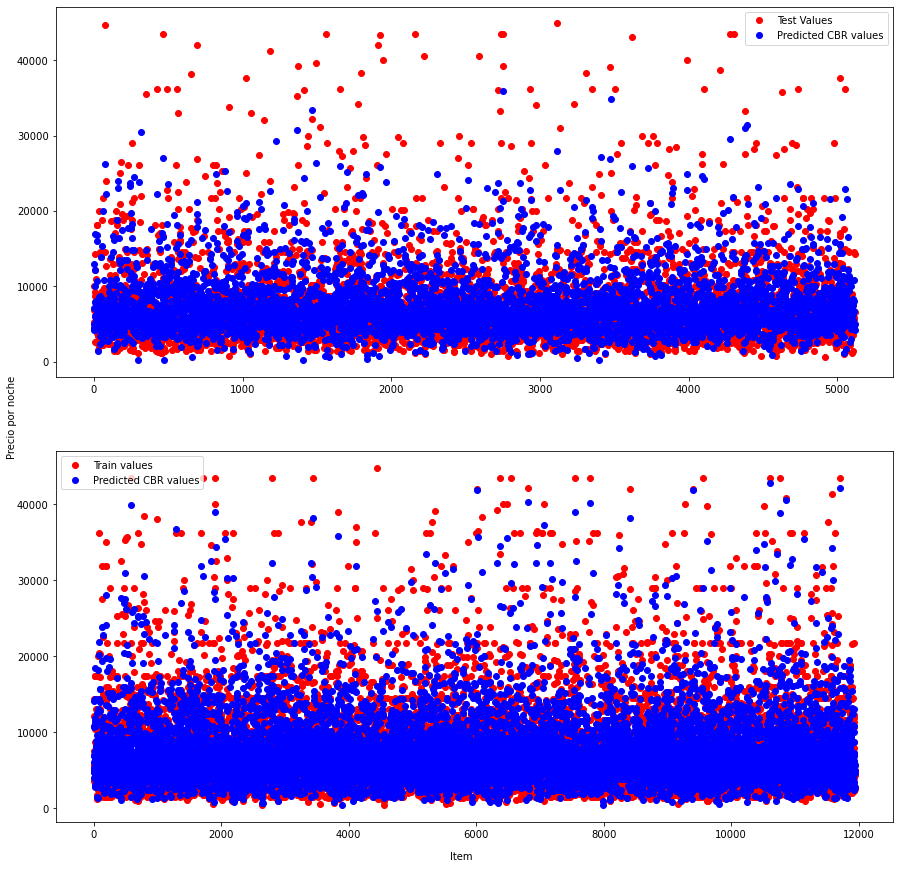

In [48]:
#Gráfico de los valores vs los predecidos
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

axes[0].plot([i for i in range(len(y_test))],y_test, 'ro', label="Test Values")
axes[0].plot([i for i in range(len(y_test))],y_pred_test_cbr, 'bo', label="Predicted CBR values")
axes[0].legend()

axes[1].plot([i for i in range(len(y_train))],y_train, 'ro', label="Train values")
axes[1].plot([i for i in range(len(y_train))],y_pred_train_cbr, 'bo', label="Predicted CBR values")
axes[1].legend()

fig.text(0.5, 0.09, 'Item', ha='center')
fig.text(0.08, 0.5, 'Precio por noche', va='center', rotation='vertical')
plt.show()

In [24]:
# Guardar modelo

joblib.dump(lgb_grid.best_estimator_,'model.sav')

['model.sav']